<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download--Datasets" data-toc-modified-id="Download--Datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download  Datasets</a></span><ul class="toc-item"><li><span><a href="#Looking-at-a-record-in-the-PyTorch-dataset-object:" data-toc-modified-id="Looking-at-a-record-in-the-PyTorch-dataset-object:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Looking at a record in the PyTorch dataset object:</a></span></li><li><span><a href="#Visualize-a-graph" data-toc-modified-id="Visualize-a-graph-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualize a graph</a></span></li><li><span><a href="#Visualize-a-molecule" data-toc-modified-id="Visualize-a-molecule-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Visualize a molecule</a></span></li></ul></li><li><span><a href="#The-Target" data-toc-modified-id="The-Target-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The Target</a></span><ul class="toc-item"><li><span><a href="#Normalize-targets" data-toc-modified-id="Normalize-targets-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Normalize targets</a></span></li><li><span><a href="#Plot-distribution" data-toc-modified-id="Plot-distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot distribution</a></span></li></ul></li><li><span><a href="#Split-datasets" data-toc-modified-id="Split-datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Split datasets</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Trainning" data-toc-modified-id="Trainning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Trainning</a></span></li></ul></div>

# Graph attention networks (GAT) implementation with QM9 datasets

- Adapted from
    - https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/Tutorial3.ipynb
    - https://github.com/rusty1s/pytorch_geometric/blob/master/examples/qm9_nn_conv.py

In [1]:
import os

import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, Softplus
from rdkit import Chem
import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.data import DataLoader
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils import from_networkx, to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats

## Download  Datasets

- The QM9 dataset, containing energies and other properties of small organic molecules, is included as an example dataset in Pytorch Geometric. 
- https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm9.html 
- Beware: Running this code will download the entire data set to the specified directory (unless it has already been downloaded).

In [2]:
class MyTransform(object):
    def __call__(self, data):
        # Specify target.
        data.y = data.y[:, target]
        return data


class Complete(object):
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

In [3]:
target = 0 # Dipole moment  
path = os.path.join(os.path.abspath(''),  'data', 'QM9')
transform = T.Compose([MyTransform(), Complete(), T.Distance(norm=False)])
dataset = QM9(path, transform=transform).shuffle()

In [4]:
print('Len dataset:', len(dataset))
print('num_classes:', dataset.num_classes)
print('num_node_features:', dataset.num_node_features)


Len dataset: 130831
num_classes: 19
num_node_features: 11


### Looking at a record in the PyTorch dataset object:

In [5]:
dataset[0]

Data(edge_attr=[210, 5], edge_index=[2, 210], idx=[1], name="gdb_51683", pos=[15, 3], x=[15, 11], y=[1], z=[15])

### Visualize a graph

In [6]:
def visualize(h, color=None, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f"Epoch: {epoch}, Loss: {loss.item():.4f}", fontsize=16)
    elif color is None:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False)

    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False, node_color=color, cmap="tab20")
    plt.show()

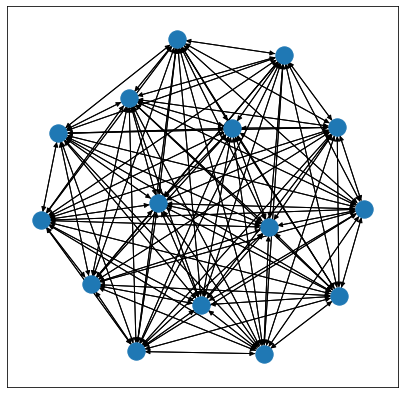

In [7]:
G = to_networkx(dataset[0])
visualize(G,)

In [8]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 15
Number of edges: 210
Average in degree:  14.0000
Average out degree:  14.0000


### Visualize a molecule

In [9]:
# The raw rdkit molecules
qm9_raw = Chem.SDMolSupplier(dataset.raw_paths[0], removeHs=True, sanitize=True)
gdb1_raw = next(iter(qm9_raw))

## The Target

### Normalize targets 

In [10]:
# Normalize targets to mean = 0 and std = 1.
mean = dataset.data.y.mean(dim=0, keepdim=True)
std = dataset.data.y.std(dim=0, keepdim=True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean[:, target].item(), std[:, target].item()

In [11]:
class Normalizer(object):
    """Normalize a Tensor and restore it later. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [12]:
sample_target = dataset.data.y[:, target].unsqueeze(1)
normalizer = Normalizer(sample_target)

### Plot distribution

In [13]:
def distribution_plot(data, prop='property'):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    df = pd.DataFrame(data, columns=["x"])
    sns.histplot(df["x"], kde=True, stat="density", linewidth=0)
    plt.title('Distribution Plot')
    plt.xlabel(prop, fontsize=15)
    plt.ylabel('Density', fontsize=15)

    plt.subplot(1, 2, 2)

    res = stats.probplot(data, plot=plt)
    plt.tight_layout()
#     plt.savefig('images/distribution_' + prop + '.png', dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

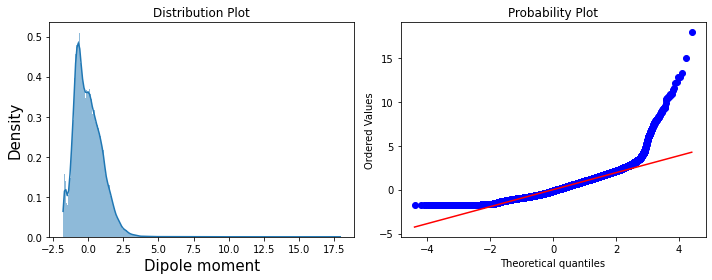

In [14]:
data_y =  dataset.data.y[:, target].cpu().detach().numpy()
distribution_plot(data_y ,'Dipole moment')

## Split datasets

In [31]:
test_dataset = dataset[:500]
val_dataset = dataset[500:1000]
train_dataset = dataset[1000:3000]
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

##  Model

In [32]:
from torch_geometric.nn import  GATConv, global_add_pool
from torch.nn import Linear, Softplus

In [33]:
class  GATConvtorch(torch.nn.Module):
    def __init__(self, in_channels,head   ):
        super( GATConvtorch, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(in_channels, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, 1, concat=False,
                             heads=self.out_head, dropout=0.6)
        
        
        # First linear layer
        self.conv_to_fc = Linear(1,in_channels * 2)
        self.conv_to_fc_softplus = Softplus()

        # Output layer
        self.fc_out = Linear(in_channels * 2, 1)


    def forward(self, x, edge_index , batch_index):
                
#         x = F.dropout(x, p=0.6, training=self.training)
        x = F.dropout(x, p=0.6)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6)
        x = self.conv2(x, edge_index)
        
        # 3. Global Pooling
        crys_fea = global_add_pool(x, batch_index)
        
        
        crys_fea = self.conv_to_fc(self.conv_to_fc_softplus(crys_fea))
        crys_fea = self.conv_to_fc_softplus(crys_fea)
#      
        out = self.fc_out(crys_fea)
        
        return  out 

## Trainning

In [34]:
def mae(prediction, target):
    """
    Computes the mean absolute error between prediction and target
    Parameters
    ----------
    prediction: torch.Tensor (N, 1)
    target: torch.Tensor (N, 1)
    """
    return torch.mean(torch.abs(target - prediction))

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
model =  GATConvtorch(dataset.num_features,8 ).to(device)
print(model)

GATConvtorch(
  (conv1): GATConv(11, 8, heads=8)
  (conv2): GATConv(64, 1, heads=1)
  (conv_to_fc): Linear(in_features=1, out_features=22, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1, threshold=20)
  (fc_out): Linear(in_features=22, out_features=1, bias=True)
)


In [36]:
def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        target_normed = normalizer.norm(data.y)
        
        data = data.to(device)
        input_var = (data.x, data.edge_index, data.batch)
        optimizer.zero_grad()
        pred = model(*input_var)
        loss = F.mse_loss(pred, target_normed.unsqueeze(1))
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [37]:

def test(loader):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        input_var = (data.x, data.edge_index, data.batch)

        pred = model(*input_var)
        error += mae(normalizer.denorm(pred.data.cpu()), data.y.unsqueeze(1))  # MAE
    return error / len(loader.dataset)

In [38]:

model =  GATConvtorch(dataset.num_features,8 ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.7, patience=5,
                                                       min_lr=0.00001)

In [39]:
print(model)

GATConvtorch(
  (conv1): GATConv(11, 8, heads=8)
  (conv2): GATConv(64, 1, heads=1)
  (conv_to_fc): Linear(in_features=1, out_features=22, bias=True)
  (conv_to_fc_softplus): Softplus(beta=1, threshold=20)
  (fc_out): Linear(in_features=22, out_features=1, bias=True)
)


In [42]:
best_val_error = 10000
for epoch in range(1, 10):
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train(epoch)
    val_error = test(val_loader)
    scheduler.step(val_error)

    if  val_error <= best_val_error:
        test_error = test(test_loader)
        best_val_error = val_error

    print('Epoch: {:03d}, LR: {:7f}, Loss: {:.7f}, Validation MAE: {:.7f}, '
          'Test MAE: {:.7f}'.format(epoch, lr, loss, val_error, test_error))

Epoch: 001, LR: 0.000700, Loss: 0.0355526, Validation MAE: 0.0062034, Test MAE: 0.0066641
Epoch: 002, LR: 0.000700, Loss: 0.0354866, Validation MAE: 0.0061983, Test MAE: 0.0066608
Epoch: 003, LR: 0.000700, Loss: 0.0360565, Validation MAE: 0.0062040, Test MAE: 0.0066608
Epoch: 004, LR: 0.000700, Loss: 0.0377776, Validation MAE: 0.0061765, Test MAE: 0.0066462
Epoch: 005, LR: 0.000490, Loss: 0.0356773, Validation MAE: 0.0062059, Test MAE: 0.0066462
Epoch: 006, LR: 0.000490, Loss: 0.0356896, Validation MAE: 0.0062013, Test MAE: 0.0066462
Epoch: 007, LR: 0.000490, Loss: 0.0351376, Validation MAE: 0.0062020, Test MAE: 0.0066462
Epoch: 008, LR: 0.000490, Loss: 0.0351503, Validation MAE: 0.0062013, Test MAE: 0.0066462
Epoch: 009, LR: 0.000490, Loss: 0.0351722, Validation MAE: 0.0061905, Test MAE: 0.0066462


In [41]:
# class GAT(torch.nn.Module):
#     def __init__(self):
#         super(GAT, self).__init__()
#         self.hid = 8
#         self.in_head = 8
#         self.out_head = 1
        
        
#         self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
#         self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
#                              heads=self.out_head, dropout=0.6)
        
        

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
                
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)
        
#         return F.log_softmax(x, dim=1)
    
    
    
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

# model = GAT().to(device)
# data = dataset[0].to(device)


# optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# model.train()
# for epoch in range(1000):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
#     if epoch%200 == 0:
#         print(loss)
    
#     loss.backward()
#     optimizer.step()